## Finite Difference Methods
We will solve the Black and Scholes PDE for the `European Call Option` by the numerical approach called a `Finite difference Method.`

The mathematical formulation for this problem is:
$$
\Biggl\{
\begin{split}
\frac{\partial V}{\partial t} + r S_t \frac{\partial V}{\partial S} +  \frac{1}{2} \sigma^2 S_t^2 \frac{\partial^2 V}{\partial S^2} - r V_t &= 0 \\
\text{Boundary Condition:}\qquad V(T,S_T) &= max\{S_T-K,0\}
\end{split}
\Biggl\}
$$

### Finite Difference Grid
We plan to solve the Black-Scholes PDE by approximating the option price $V(t,S)$ on a finite grid of points $(t_i,S_j)$ in a rectangular region $[0,T] \times [S_{\min},S_{\max}]$. Our grid will have $N$ steps in the $t$ direction and $M$ steps in the $S$ direction, giving a total of $(N+1)(M+1)$ points. 

[]

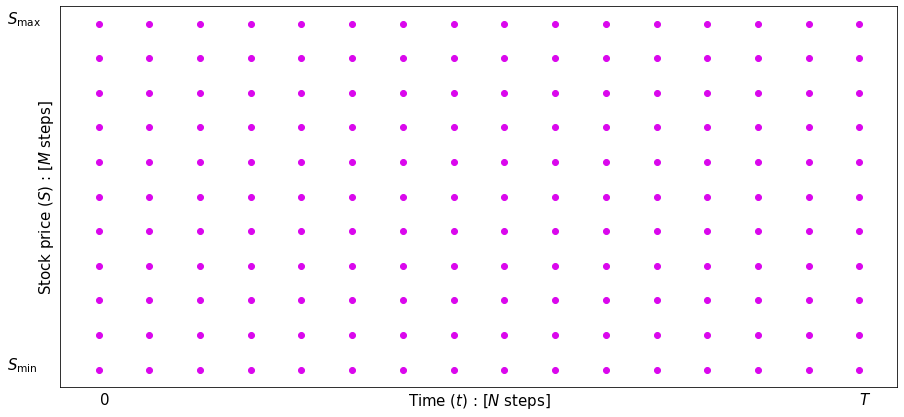

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import mathfinance as mf
plt.rcParams['figure.figsize'] = [15,7]

S_min = 0.8
S_max = 1.2
T = 1
N = 15
M = 10
S = np.linspace(S_min,S_max, M+1)
t = np.linspace(0, T, N+1)
S_mesh, t_mesh = np.meshgrid(S,t)

ax = plt.gca()
ax.scatter( t_mesh, S_mesh, color = '#da07ed')
ax.set_xlabel('Time ($t$) : [$N$ steps]', fontsize = 15)
ax.set_ylabel('Stock price ($S$) : [$M$ steps]', fontsize = 15)
ax.text( -0.12, S_min, '$S_{\min}$', fontsize = 15)
ax.text( -0.12, S_max, '$S_{\max}$', fontsize = 15)
ax.text( 0, S_min - 0.04, '$0$',fontsize = 15)
ax.text( T,S_min-0.04, '$T$', fontsize = 15)
ax.set_yticks([])
ax.set_xticks([])

We aim to find the value for option price $V$ at every point in the grid and produce a 3-d plot.

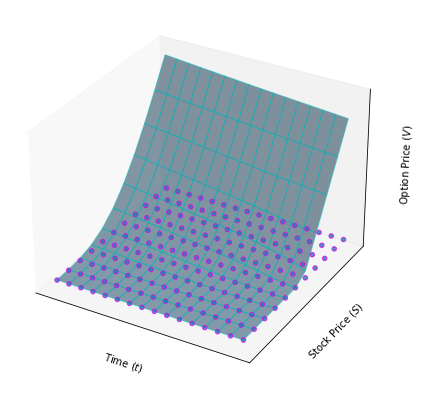

In [7]:
K = 1.03
sigma = 0.1
r = 0.02
V = mf.blackscholes(r, S_mesh, K, T+0.00001, sigma, t_mesh, type="call") # I'm avoiding a division by zero by adding the 0.00001
ax = plt.gca(projection='3d')
ax.plot_surface(t_mesh,S_mesh,V, alpha=0.5,edgecolor='c');
ax.scatter(t_mesh,S_mesh,0, alpha=0.8,edgecolor='#da07ed');
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('Time ($t$)')
ax.set_ylabel('Stock Price ($S$)')
ax.set_zlabel('Option Price ($V$)');

## Boundary conditions
We don't have any initial condition for Black-Scholes PDE. But we do have final/terminal condition. The boundary condition is $V(S,T)=\max\{S-K,0\}$ and we solve PDE by stepping *backwards* in time. If we want to have a well-defined PDE on our finite rectangular grid we will also need to know Top Boundary condition $V(t,S_{\max})$ and Bottom Boundary condition $V(t,S_{\min})$. If we take resonable values for these Top and Bottom BC's, it will be possible to solve the PDE on our grid, so the PDE doesn't make sense without these BC's. We will make resonable estimate for these.

[NOTE: If we had a $\infty$-region that we are solving our PDE on, then instead of specifying the values at Top & Bottom,
we specify the rate of decay or rate of growth of the solution . But we would need additional BC's to solve the PDE.]

<img src="pics/boundary.jpg" width="800" height="400"/>

### Estimating the Top and Bottom Boundary conditions
- `Top Boundary Condition`:\
A derivative that pays out $S_T-K$ (without any maximum) at time $T$ has value $S_t-e^{-r(T-t)}K$ by a simple replication argument. You can replicate the payout by purchasing one unit of the stock and putting $e^{-r{T-t}}K$ into a risk-free account. So for large $S$ we will have $V(t,S)\approx S-e^{-r(T-t)}K$(assuming always end up in the money).
To be more precise, we know that the probability of a draw from a normal distribution being more than $8$ standard deviations from the mean is negligible.
We know that the change in the log of the stock price from time $t$ to time $T$ is normally distributed with standard deviation $\sigma \sqrt{T-t}$. We will neglect the drift, which is reasonable over short time horizons. So if we are given that
$$\log(S_t) - \log(K) > 8 \sigma \sqrt{T-t}$$
then the chance that $S_T < K$ is negligible.
So if we take $S_{\max}= K \exp( 8 \sigma T )$ we can estimate $V(t,S_{\max})$ by the replication argument.
From this estimation argument, we will take as our top 
boundary condition
$$
\boxed{
\begin{split}
S_{\max}&= K \exp(8 \sigma \sqrt{T})\\
V(t,S_{\max})&=S_{\max}-e^{-r(T-t)}K
\end{split}
} \longrightarrow \text{Top Boundary Condition Estimation}
$$
- `Bottom Boundary Condition`:\
The bottom boundary condition is very simple for European Call. If $S_t=0$ then the SDE for geometric Brownian motion implies $S_T=0$ and so the call option will be worthless at time $T$.
Hence, we can estimate bottom boundary condition as:
$$
\boxed{
\begin{split}
S_{\min}&=0 \\
V(t,S_{\min})&=0
\end{split}
}\longrightarrow \text{Bottom Boundary Condition Estimation}
$$

So, we started with a PDE defined on the $[0,T]\times[-\infty,\infty]$. We imposed boundary conditions at the top and bottom to give a PDE on a finite region. We will approximate $V$ on a grid of $(N+1)\times(M+1)$ points lying in the region $[0,T]\times[S_{\min},S_{\max}]$
where
$$ S_{\min}=0 $$
$$ S_{\max}= K \exp( 8 \sigma \sqrt{T}) $$
And we will take as boundary conditions
$$
\boxed{
\begin{split}
V(t,S_{\min})&=0 \\
V(t,S_{\max})&=S_{\max} - e^{-r(T-t)}  K \\
V(T,S_T)&=\max\{S_T-K,0\}
\end{split}
}
$$
We use this to calculate $V$ at all the other grid points by using a discrete approximation to the PDE
$$
\boxed{
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - rV = 0.}
$$

## Discretization
We will approximate the PDE by a large multidimensional family of ODE’s. Then we will solve the ODE.
### Space Discretization
Let us now discretize the process in the space direction i.e. the Stock Price. We number the points in our stock price grid $\{S_{\min}=S_0, S_1, \ldots, S_M=S_{\max}\}$. We will have $M$ steps, hence $(M+1)$ number of points.
So
$$
\begin{split}
\biggl\{S_i&:=S_{\min}+i \delta S \biggl\}\\
\text{where} \qquad \delta S&:= \frac{S_{\max}-S_{\min}}{M}
\end{split}
$$
Now we will discretize all the derivatives that are with respect to $S$. Let us write $V^i_t:=V(t,S_i)$ for the corresponding values of $V$. Using the `Central Difference Estimate:`
$$
\boxed{
\frac{\partial V}{\partial S} (t,S_i) \approx \frac{V(t,S_i+\delta S)-V(t,S_i-\delta S)}{2 \delta S} = \frac{V(t,S_{i+1})-V(t,S_{i-1})}{2\,\delta S} = \frac{V^{i+1}_t - V^{i-1}_t}{2\,\delta S}}
$$
Similarly
$$
\boxed{
\frac{\partial^2 V}{\partial S^2} (t,S_i) \approx \frac{V(t,S_{i+1})-2V(t,S_i)+V(t,S_{i-1})}{(\delta S)^2} = \frac{V^{i+1}_t - 2 V^{i}_t + V^{i-1}_t}{(\delta S)^2}}
$$

### System of ODEs
The Black-Scholes PDE is:
$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S_i^2 \frac{\partial^2 V}{\partial S^2} + r S_i \frac{\partial V}{\partial S} - r V^i = 0$$
So we may approximate $V(t,S)$ at the grid points $S_i$ by solving the system of *$(M-1)$ ODEs for $V^i$*.

$$
\boxed{
\frac{d V^i}{dt} + \frac{1}{2} \sigma^2 S_i^2 \frac{V^{i+1}-2 V^{i} + V^{i-1}}{(\delta S)^2} + r S_i \frac{V^{i+1}-V^{i-1}}{2\,\delta S} - r V^i \approx 0} \qquad \longrightarrow \text{Finite Difference Equation for Black-Scholes PDE}
$$

for $i=1,2, \ldots, M-1$.
<p style="text-align: center;">
    <img src="pics/stencil.jpg" width="200" height="100"/>
    <br> 
    <em><strong>Fig: Stencil for FD Method</strong></em>
</p>

Rearranging the system of ODEs gives
$$
\begin{split}
\frac{d V^i}{dt} &\approx  \biggl(-\frac{\sigma^2 S_i^2}{2 (\delta S)^2} + \frac{r S_i}{2\, \delta S}\biggl) V^{i-1} + \biggl(r + \frac{\sigma^2 S_i^2}{(\delta S)^2 }\biggl)V^i_t + \biggl(-\frac{\sigma^2 S_i^2}{2 (\delta S)^2} - \frac{r S_i}{2\, \delta S}\biggl)V^{i+1} \\
\frac{d V^i}{dt} &\approx a_i V^{i-1}_t + b_i V^i_t + c_i V^{i+1}_t
\end{split}
$$

with
$$a_i := -\frac{\sigma^2 S_i^2}{2 (\delta S)^2} + \frac{r S_i}{2\, \delta S}, \qquad b_i := r + \frac{\sigma^2 S_i^2}{(\delta S)^2 }, \qquad c_i := -\frac{\sigma^2 S_i^2}{2 (\delta S)^2} - \frac{r S_i}{2\, \delta S} $$

### Matrix notation

So we have the ODE
$$\frac{d V^i}{dt} \approx a_i V^{i-1}_t + b_i V^i_t + c_i V^{i+1}_t$$
which holds for $i=1,2,\ldots, M-1$.

Together with the boundary conditions
$$V^{M}_t=S_{\max}-e^{-r(T-t)}K$$
and
$$V^0_t=0.$$ for nodes $i=M$ and $i=0$.

We can write our system of ODEs in matrix form as:
$$
\frac{d{\mathbf V}}{dt}
= \frac{d}{dt} \begin{pmatrix}
V^1 \\
V^2 \\
V^3 \\
\ldots \\
V^{M-2} \\
V^{M-1}
\end{pmatrix}
\approx \underbrace{\begin{pmatrix}
b_1 & c_1 & 0 & 0 & \ldots & 0 & 0 \\
a_2 & b_2 & c_2 & 0 & \ldots & 0 &0 \\
0 & a_3 & b_3 & c_3 & \ldots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & & \vdots & \vdots \\
0 & 0 & 0 & 0 & \ldots & b_{M-2} & c_{M-2} \\
0 & 0 & 0 & 0 & \ldots & a_{M-1} & b_{M-1}
\end{pmatrix}}_{\Lambda}
\underbrace{\begin{pmatrix}
V^1 \\
V^2 \\
V^3 \\
\ldots \\
V^{M-2} \\
V^{M-1}
\end{pmatrix}}_{{\mathbf V}_t}
+ \underbrace{\begin{pmatrix}
a_1 V^0_t \\
0 \\
0  \\
\vdots \\
0 \\
c_{M-1} V^M_t
\end{pmatrix}}_{{\mathbf W}_t}
$$
where ${\mathbf V}_t$ denote the **vector** containing the components $V^i_t$ for $i=1,\ldots,M-1$ and $\Lambda$ is a **Matrix** and ${\mathbf W}_t$ is a **vector**.

We can now write our system of ODE's succinctly as:
$$
\begin{equation}
\biggl\{\frac{d{\mathbf V}}{dt} \approx \Lambda {\mathbf V}_t + {\mathbf W}_t\biggl\} \label{eq:FD} \tag{$\mathbf{\dagger}$}
\end{equation}
$$

### Methods for solving the system of ODE's \eqref{eq:FD}
We will explore three different schemes for solving the above system of ODE's \eqref{eq:FD}.

#### **The Explicit Method**
Using **Backward differences** we get the scheme:
$$
\begin{split}
\frac{\mathbf{V}_t - \mathbf{V}_{t-\delta t}}{\delta t} &\approx \Lambda {\mathbf V}_t + {\mathbf W}_t.\\
\biggl\{\mathbf{V}_{t-\delta t}&\approx({\mathbf 1} - \Lambda \, \delta t) {\mathbf V}_t - \delta t {\mathbf W}_t\biggl\}\\
& \qquad \text{where we denote }\mathbf 1 \text{ as the identity matrix.}
\end{split}
$$
This is an **Explicit Method for solving the PDE**. This is called Explicit since it is a straightforward equation describing $V_{t+\delta t}$
which you can apply iteratively and its sitting by itself on LHS. As we are working backwards in time, using backward differences is essentially the same as solving the ODE using the Euler method. We can expect this method to be unstable unless $\delta t$ is small. Each vector ${\mathbf V}_t$ corresponds to a column in our grid of points. We start with the vector ${\mathbf V}_T$ which is known from the final boundary condition $V(T,S_T)=\max\{S_T-K,0\}$ and we march backwards in time following this scheme. The visualisation of this is given below:

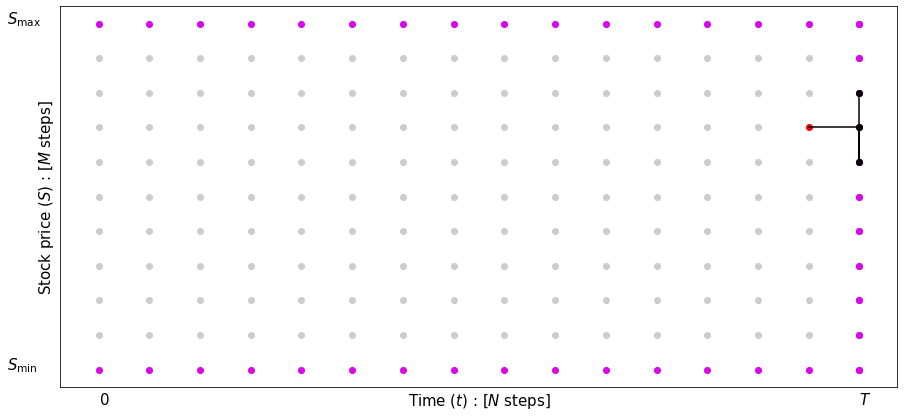

In [76]:
def plot_grid( n, p ):
    S_min = 0.8
    S_max = 1.2
    T = 1
    N = 15
    M = 10
    S = np.linspace(S_min,S_max, M+1)
    t = np.linspace(0, T, N+1)
    S_mesh1, t_mesh1 = np.meshgrid(S,t[0:n])
    S_mesh2, t_mesh2 = np.meshgrid(S,t[n:N+1])

    ax = plt.gca()
    ax.scatter( t_mesh1, S_mesh1, color=(0.8,0.8,0.8))
    ax.scatter( np.concatenate( [ t, t, T*np.ones(M+1)] ),
                np.concatenate( [ S_min*np.ones(N+1 ),S_max*np.ones(N+1), S ]),
                color='#da07ed')
    ax.scatter( t_mesh2, S_mesh2, color = '#da07ed' )

    ax.set_xlabel('Time ($t$) : [$N$ steps]',fontsize = 15)
    ax.set_ylabel('Stock price ($S$) : [$M$ steps]',fontsize = 15)
    ax.text( -0.12, S_min, '$S_{\min}$',fontsize = 15)
    ax.text( -0.12, S_max, '$S_{\max}$',fontsize = 15)
    ax.text( 0, S_min - 0.04, '$0$',fontsize = 15)
    ax.text( T,S_min-0.04, '$T$',fontsize = 15)
    ax.set_yticks([])
    ax.set_xticks([])
    
    j = M-3
    ax.plot( [t[n],t[n],t[n],t[n-1]], [S[j+1],S[j-1],S[j], S[j]], color = 'black')
    ax.scatter( [t[n],t[n],t[n]], [S[j+1],S[j-1],S[j]], color = 'black')
    ax.scatter( t[n-1],S[j],color = 'r')
    # ax.annotate(r'$V_{T- {%d} \delta t}$' % p, (t[n-1],S[j]), ha='left', fontsize=15)
    
plot_grid(15,1)

In the diagram above, the `purple dots` denote the `Boundary Conditions`i.e. the Top, Bottom and the Terminal conditions. We can compute the value at the red dot $V_{T-\delta t}^i$ from three values at time $T$ i.e.$V_{T}^{i+1},V_{T}^{i},V_{T}^{i-1}$as shown by the black lines. This *stencil* shows the visualisation of which values are used in our finite difference scheme. Once we have computed all values for time points $T-\delta t$ we can move back one time step and calculate values for $V_{T-2\delta t}^i$. We keep repeating and moving backwards in time until we reach time $t=0$.

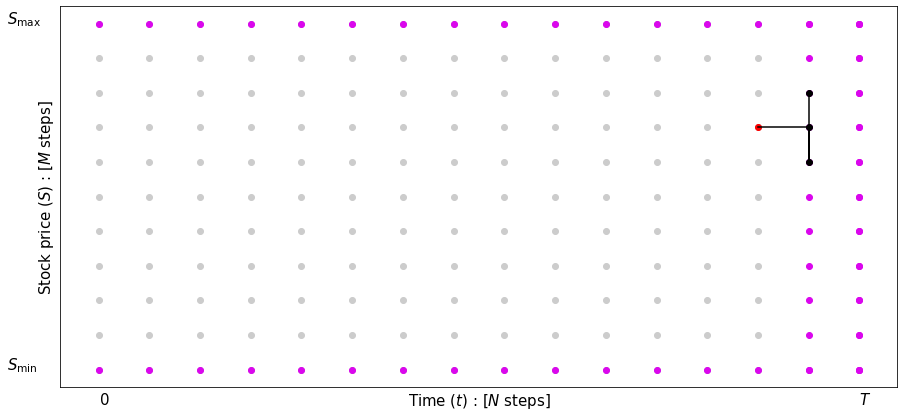

In [77]:
plot_grid(14,2)

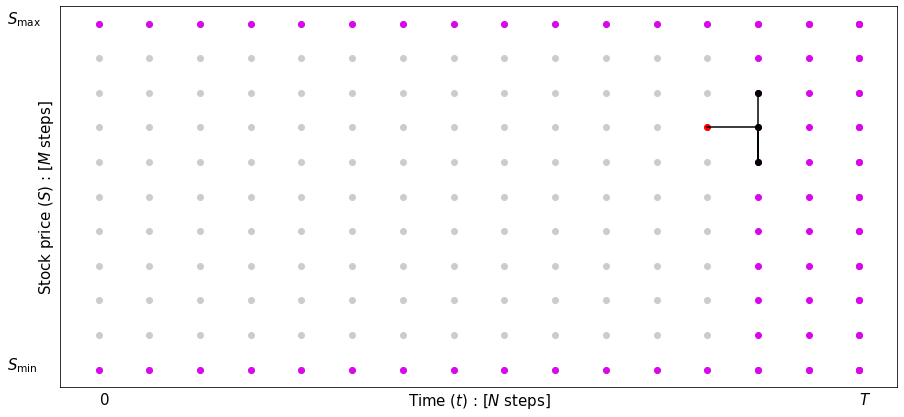

In [78]:
plot_grid(13,3)

$\vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad $
$\vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad \vdots \qquad $

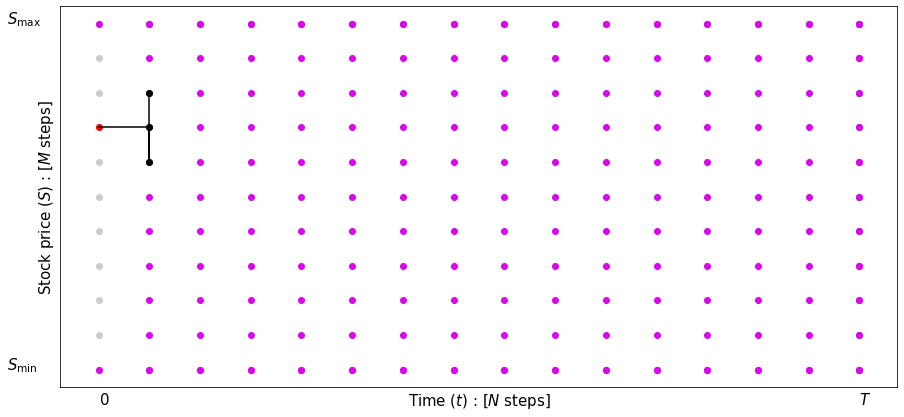

In [79]:
plot_grid(1,15)

#### **The Implicit Method**
Using **Forward differences** we get the scheme:
$$
\begin{split}
\frac{\mathbf{V}_{t+\delta t} - \mathbf{V}_{t}}{\delta t} &\approx \Lambda {\mathbf V}_t + {\mathbf W}_t.\\
\text{which can be rearranged to}\\
\biggl\{\mathbf{V}_{t+\delta t}&\approx({\mathbf 1} + \Lambda \, \delta t) {\mathbf V}_t + \delta t {\mathbf W}_t.\biggl\}
\end{split}
$$
This is called the **Implicit Method for solving the PDE**. This is because to calculate ${\mathbf V}_t$ we will have to solve this system of $M-1$ linear equations. We may write
$${\mathbf V_t}\approx({\mathbf 1} + \Lambda \, \delta t)^{-1} (\mathbf{V}_{t+\delta t}-\delta t {\mathbf W}_t )$$
but this is an inefficient way of calculating ${\mathbf V}_t$. When you solve a system of simultaneous equations you usually use the *method of row-reduction*, also known as **Gaussian Elimination**. This is much more efficient than computing the inverse and also introduces less rounding errors. To solve a general linear equation for $x$ given by $A x = b$ in Python we should use `numpy.linalg.solve`. If the matrix is mostly zeros, you should use `scipy.sparse.linalg.spsolve`. This is a particularly simple form of equation since $\Lambda$ is tridiagonal, so for optimal performance you could use `scipy.linalg.solve_banded` which is designed to solve Tridiagonal equations efficiently.

#### **The Crank-Nicolson Method**
Using *Central differences* we get the scheme:
$$\frac{\mathbf{V}_{t+\delta t} - \mathbf{V}_{t}}{\delta t} \approx \tfrac{1}{2} \Lambda ({\mathbf V}_{t+\delta t} + {\mathbf V}_{t}) + \tfrac{1}{2}({\mathbf W}_{t+\delta t}+{\mathbf W}_t)$$
This is basically taking Average of estimates on either side. Rearranging we get the `Crank-Nicolson scheme`:
$$ \biggl\{({\mathbf 1}+\tfrac{1}{2}\Lambda \, \delta t) {\mathbf V}_{t} \approx ({\mathbf 1}-\tfrac{1}{2}\Lambda \, \delta t) {\mathbf V}_{t+\delta t} - \tfrac{1}{2} \delta t({\mathbf W}_{t+\delta t}+{\mathbf W}_t)\biggl\}
$$
This is also an implicit method as we must solve this linear equation at each stage of our iteration.
Again we may write:
$${\mathbf V}_{t} \approx ({\mathbf 1}+\tfrac{1}{2}\Lambda)^{-1} \left( ({\mathbf 1}-\tfrac{1}{2}\Lambda) {\mathbf V}_{t+\delta t} - \tfrac{1}{2} \delta t({\mathbf W}_{t+\delta t}+{\mathbf W}_t) \right)$$
but once again it is better to solve the equations using `numpy.linalg.solve` routines than calculating Inverses.

- In **summary**:\
To price a call option using finite difference methods we may use either the `Explicit, Implicit or Crank-Nicolson schemes`. These schemes may be written as
$$\mathbf{V}_{t-\delta t}\approx({\mathbf 1} - \Lambda \, \delta t) {\mathbf V}_t - \delta t {\mathbf W}_t \qquad \Longrightarrow \qquad\text{Explicit Backward Scheme}$$
$${\mathbf V_t}\approx({\mathbf 1} + \Lambda \, \delta t)^{-1} (\mathbf{V}_{t+\delta t}-\delta t {\mathbf W}_t)\qquad \Longrightarrow \qquad\text{Implicit Forward Scheme}$$
$${\mathbf V}_{t} \approx ({\mathbf 1}+\tfrac{1}{2}\Lambda)^{-1} \left( ({\mathbf 1}-\tfrac{1}{2}\Lambda) {\mathbf V}_{t+\delta t} - \tfrac{1}{2}\delta t ({\mathbf W}_{t+\delta t}+{\mathbf W}_t) \right)\qquad \Longrightarrow \qquad\text{Implicit Crank-Nicolson Scheme}$$
When implementing the schemes use an efficient method such as  `scipy.sparse.linalg.spsolve` rather than actually performing the matrix inverse.
The vector ${\mathbf W}$ encodes the top and bottom boundary conditions. The matrix $\Lambda$ is a *tridiagonal matrix*.
Explicit formulae for ${\mathbf W}$ and $\Lambda$ are given above.
To start the iteration we use the final/terminal condition
$$V^{i}_T=\max\{S_i-K,0\}$$
which comes from the option payoff. We then step backwards in time to compute $V$ at time $0$ which is the price of an Option.

### Aside: Boundary Conditions for other Option types
- For an **European Put Option** with strike $K$ and maturity $T$, the payoff or terminal condition is $V(T,S_{T}) = max\{K-S_T,0\}$. Choosing same $S_{\max}$ and $S_{\min}=0$ as for a call option, we find that at the top boundary $V(t,S_{\max}) = 0$ and at the bottom boundary we have $V(t,S_{\min}) = e^{-r(T-t)}  K$.
$$
\boxed{
\begin{split}
V(t,S_{\min})&=e^{-r(T-t)}  K \\
V(t,S_{\max})&=0 \\
V(T,S_T)&=\max\{K-S_T,0\}
\end{split}
}
$$
- A **Digital Call Option** with strike $K$ gives a payoff at maturity $T$ of
$$
\begin{cases}
1 & S_T>K \\
0 & \text{otherwise}
\end{cases}
$$
Choosing same $S_{\max}$ and $S_{\min}=0$ as for a call option, we find that at the top boundary $V(t,S_{\max}) = e^{-r(T-t)}$ and at the bottom boundary we have $V(t,S_{\min}) = 0$.
$$
\boxed{
\begin{split}
V(t,S_{\min})&=0 \\
V(t,S_{\max})&=e^{-r(T-t)} \\
V(T,S_T)&=
\begin{cases}
1 & S_T>K \\
0 & \text{otherwise}
\end{cases}
\end{split}
}
$$

# Implementation Of Finite Difference Method in Python
### Explicit Method:
We now implement the finite difference method to price a call option by solving the Black Scholes PDE. We will use the `Explicit Method` first.
The steps involve:
- Initialising the grid and an array $V$ to store the solution.
- Set the Boundary Conditions and apply the recurrence relation: $$\boxed{\mathbf{V}_{t-\delta t}\approx({\mathbf 1} - \Lambda \, \delta t) {\mathbf V}_t - \delta t {\mathbf W}_t}$$

### Function to compute the matrix $\mathbf{\Lambda}$  and the vector ${\mathbf W}_t$

We will write a function to compute *tridiagonal matrix* $\mathbf{\Lambda}$ and the vector ${\mathbf W}_t$ whose entries are determined by vectors $\mathbf a$, $\mathbf b$ and $\mathbf c$ where:
$$a_i := -\frac{\sigma^2 S_i^2}{2 (\delta S)^2} + \frac{r S_i}{2\, \delta S}, \qquad b_i := r + \frac{\sigma^2 S_i^2}{(\delta S)^2 }, \qquad c_i := -\frac{\sigma^2 S_i^2}{2 (\delta S)^2} - \frac{r S_i}{2\, \delta S} $$
The best algorithm to use when performing linear algebra will depend upon whether your matrices are *sparse* (i.e. most entries are zero)
or *dense* (most entries are non-zero). For example storing an $n \times m$ dense matrix requires $O(n \times m)$ memory, but
a sparse matrix may be stored much more efficiently. We will use the `scipy.sparse` package to creates a sparse matrix. When you create a matrix
you can specify the precise format that is used to store the matrix in memory, we'll choose to use a format called 'csr' which stands for "compressed sparse row". In `scipy.sparse` package we can use dot function for Matrix Multiplication. $$\underbrace{A}_{\text{Sparse Matrix}}.dot(\underbrace{b}_{\text{numpy vector}}) \qquad \longrightarrow \text{Matrix Multiplication } Ab$$





In [83]:
import scipy.sparse as sc

def compute_vector_abc( K, T, sigma, r, S, dt, dS ):
    """S should be a vector containing all the stock points"""
    a = -sigma**2 * S**2/(2* dS**2 ) + r*S/(2*dS)  # Vector containing all values of a for i = 1,2,...,(M-1).
    b = r + sigma**2 * S**2/(dS**2)  # Vector containing all values of b for i = 1,2,...,(M-1).
    c = -sigma**2 * S**2/(2* dS**2 ) - r*S/(2*dS)  # Vector containing all values of c for i = 1,2,...,(M-1).
    return a,b,c

def compute_matrix_lambda( a,b,c ):
    """a[1:] is the Lower diagonal, b is the Main diagonal and c[:-1] is the Upper diagonal. The parameter offsets
    sets position of each diagonals."""
    return sc.diags( [a[1:],b,c[:-1]],offsets=[-1,0,1],format='csr')

def compute_vector_W(a,b,c, V0, VM):
    M = len(b)+1
    W = np.zeros(M-1)
    W[0] = a[0]*V0
    W[-1] = c[-1]*VM
    return W

Lets write the functions to set the following Boundary Conditions:
$$
\boxed{
\begin{split}
V(t,S_{\min})&=0 \\
V(t,S_{\max})&=S_{\max} - e^{-r(T-t)}  K \\
V(T,S_T)&=\max\{S_T-K,0\}
\end{split}
}
$$

In [84]:
def bottom_boundary_condition_call( K, T, S_min, r, t):
    """t should be a vector containing all the time points.
       This returns a vector of prices corresponding to the time points."""
    return np.zeros(t.shape)

def top_boundary_condition_call( K, T, S_max, r, t):
    """t should be a vector containing all the time points.
       This returns a vector of prices corresponding to the time points."""
    return S_max-np.exp(-r*(T-t))*K

def terminal_condition_call( K, T, S ):
    """S should be a vector containing all the final prices.
       This returns a vector of payoffs corresponding to the final stock prices"""
    return np.maximum(S-K,0)

We are finally ready to write a function that will price the Option using the Explicit method. For the sake of how matrix are stored in python, we will rotate our original grid by 90 degrees clockwise. Other than that everything else is same. The grid now looks like:

<p style="text-align: center;">
    <img src="pics/grid.jpg" width="700" height="800"/>
    <br> 
    <em><strong>Fig: Grid represented as Matrix in Python</strong></em>
</p>

In [104]:
def pricing_call_explicit( K, T, r, sigma, N, M):
    """Return values V is Matrix. S and t are vectors."""
    # Initialising the shape of the grid.
    dt = T/N
    S_min=0
    S_max=K*np.exp(8*sigma*np.sqrt(T))  # Should be s.t. we are unlikely to hit K. Hence, need Smax to be 8 x STD.DEV away from K.
    dS = (S_max-S_min)/M  # delta S.
    S = np.linspace(S_min,S_max,M+1)  # Vector of Stock Prices.
    t = np.linspace(0,T,N+1)  # Vector of times.
    V = np.zeros((N+1,M+1)) # Initialising option price matrix with all element zero.
    
    # Setting the Boundary Conditions.
    V[:,-1] = top_boundary_condition_call(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition_call(K,T,S_max,r,t)
    V[-1,:] = terminal_condition_call(K,T,S)
    
    # Apply the recurrence relation.
    a,b,c = compute_vector_abc(K,T,sigma,r,S[1:-1],dt,dS)  # Computing vector a,b and c.
    Lambda = compute_matrix_lambda( a,b,c)  # Computing matrix lambda.
    identity = sc.identity(M-1, format='csr')  # Identity matrix.
    
    for i in range(N,0,-1):  # Looping backwards in time.
        W = compute_vector_W(a,b,c,V[i,0],V[i,M])
        # Use `dot` to multiply a vector by a sparse matrix
        V[i-1,1:M] = (identity-Lambda*dt).dot( V[i,1:M] ) - W*dt
        
    return V, t, S

We have computed $V$ at every point in the grid, so we should be able to generate a 3-d plot of the results. For convenience we use this function which plots $V$ given the values $t$ and $S$ to use for the axes and labels everything correctly. A lot of the graph is a bit boring looking towards the boundaries, so we've zoomed in a bit on a more interesting area.

In [93]:
def plot_option_price(V,t,S):
    # We only plot the points for the first 1/3 of the stock prices so that the detail is visible.
    M = len(S)-1
    S_zoom = S[0:int(M/3)]
    V_zoom=V[:,0:int(M/3)]
    t_mesh, S_mesh = np.meshgrid(t,S_zoom)
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh,S_mesh,V_zoom.T, alpha=0.8,edgecolor='#da07ed');
    ax.set_xlabel('Time (t)', fontsize = 12)
    ax.set_ylabel('Stock price (S)', fontsize = 12)
    ax.set_zlabel('Option price', fontsize = 12)

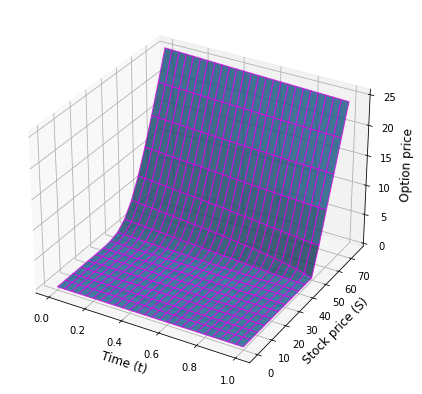

In [94]:
K = 50  # Strike price.
T = 1   # 1 Year.
sigma = 0.2  # Volatility.
r = 0.02  # Risk free rate.
N = 50  # No of steps in time direction.
M = 50  # No of steps in space direction.

V,t,S = pricing_call_explicit( K, T, r, sigma, N, M)
plot_option_price(V,t,S) 

### Instability: As step size decreases
The explicit method can be unstable if we don't have sufficient time steps. We will reduce the number of time steps to 20 and check whether any instability arises.

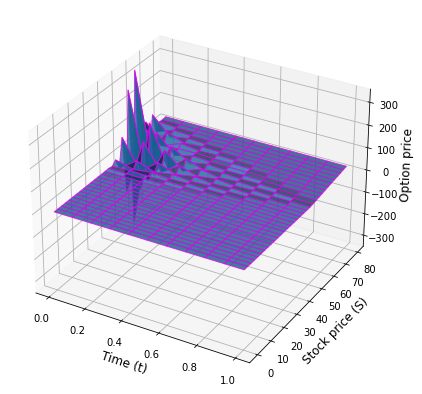

In [102]:
# Reducing Number of time step to 10.
N = 10
M = 100
V,t,S = pricing_call_explicit( K, T, r, sigma, N, M)
plot_option_price(V,t,S) 

As we can see in the above plot there is clearly `Instability`.

### Implicit Method:
We now implement the finite difference method to price a call option by solving the Black Scholes PDE using the `Implicit Method`.
We have the same boundary conditions but we use the recurrence relation:
$$\boxed{{\mathbf V_t}\approx({\mathbf 1} + \Lambda \, \delta t)^{-1} (\mathbf{V}_{t+\delta t}-\delta t {\mathbf W}_t )}$$
It is not a good idea to solve equations by computing the matrix inverse. Hence, we will do:
- "Find $V_t$ by solving following equation:
$$\underbrace{({\mathbf 1} + \Lambda \, \delta t)}_{\mathbf A} \underbrace{{\mathbf V_t}}_{\mathbf x}\approx \underbrace{(\mathbf{V}_{t+\delta t}-\delta t {\mathbf W}_t )}_{b} \quad"$$

We will solve this equation using the routine `spsolve`. This can solve the equation $Ax = b$. In our case $x=V_t$ is what we want to calculate. $A = (1+\Lambda \delta t)$ and $b = V_{t+\delta t} - \delta t W_t$. The code will essentially be same as that for the *Explicit method* except for the bit inside `for` loop.

In [105]:
def pricing_call_implicit( K, T, r, sigma, N, M):
    """Return values V is Matrix. S and t are vectors."""
    # Initialising the shape of the grid.
    dt = T/N
    S_min=0
    S_max=K*np.exp(8*sigma*np.sqrt(T))  # Should be s.t. we are unlikely to hit K. Hence, need Smax to be 8 x STD.DEV away from K.
    dS = (S_max-S_min)/M  # delta S.
    S = np.linspace(S_min,S_max,M+1)  # Vector of Stock Prices.
    t = np.linspace(0,T,N+1)  # Vector of times.
    V = np.zeros((N+1,M+1)) # Initialising option price matrix with all element zero.
    
    # Setting the Boundary Conditions.
    V[:,-1] = top_boundary_condition_call(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition_call(K,T,S_max,r,t)
    V[-1,:] = terminal_condition_call(K,T,S)
    
    # Apply the recurrence relation.
    a,b,c = compute_vector_abc(K,T,sigma,r,S[1:-1],dt,dS)  # Computing vector a,b and c.
    Lambda = compute_matrix_lambda( a,b,c)  # Computing matrix lambda.
    identity = sc.identity(M-1, format='csr')  # Identity matrix.
          
    for i in range(N-1,-1,-1):  # Looping backwards in time.
        W = compute_vector_W(a,b,c,V[i,0],V[i,M])
        V[i,1:M] = sc.linalg.spsolve(
            identity+Lambda*dt,  # A.
            V[i+1,1:M] - W*dt)   # b. in Ax=b.
        
    return V, t, S

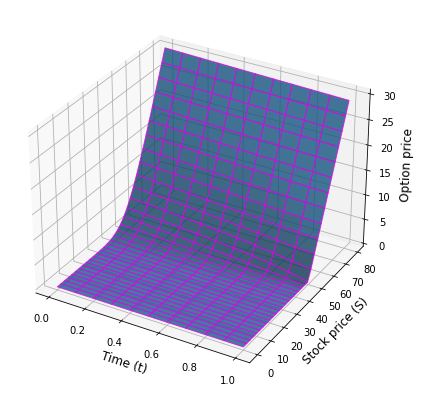

In [106]:
N = 10
M = 100
V,t,S = pricing_call_implicit( K, T, r, sigma, N, M)  # 10 time step.
plot_option_price(V,t,S)

Notice, we get `no Instability` this time even when the time step is 10(very small).

### Testing our result

We already know the analytical price of a call option from the Black-Scholes formula. So let's test that our solution matches up with the Black Scholes formula at time $0$.

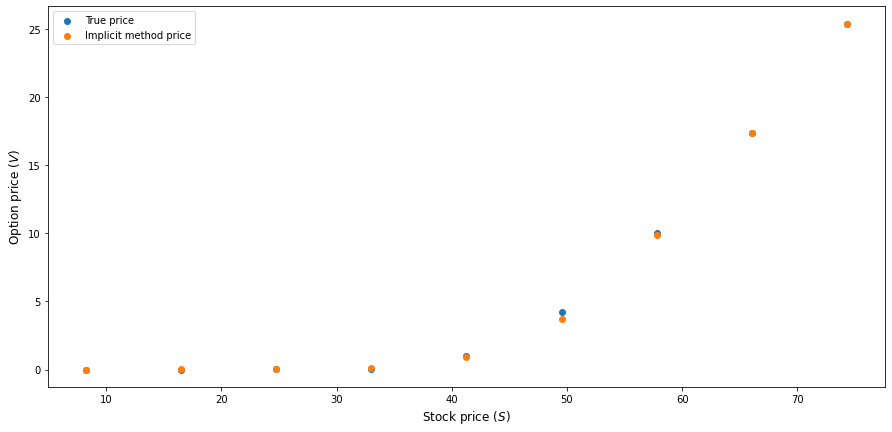

In [115]:
import mathfinance as mf
V,t,S = pricing_call_implicit( K, T, r, sigma, 5, 30)  # Here, no. of time step is N=5 and no. of space step is M=30. 
min_index =1
max_index = int(len(S)/3)
S_zoom = S[min_index:max_index]
V_true = mf.blackscholes(r, S_zoom, K, T, sigma, t=0, type="call")  # True price at time 0 for various current prices.
ax = plt.gca()
ax.scatter(S_zoom, V_true, label='True price')
ax.scatter(S_zoom, V[0,min_index:max_index], label='Implicit method price');
ax.set_xlabel('Stock price ($S$)',fontsize = 12)
ax.set_ylabel('Option price ($V$)',fontsize = 12)
ax.legend();

### The Crank Nicolson Method:
We now implement the finite difference method to price a call option by solving the Black Scholes PDE using the `Crank Nicolson Method`.
We have the same boundary conditions but we use the recurrence relation:
$$\boxed{{\mathbf V}_{t} \approx ({\mathbf 1}+\tfrac{1}{2}\Lambda \, \delta t)^{-1} \left( ({\mathbf 1}-\tfrac{1}{2}\Lambda \, \delta t) {\mathbf V}_{t+\delta t} - \tfrac{1}{2} \delta t({\mathbf W}_{t+\delta t}+{\mathbf W}_t) \right)}$$
It is not a good idea to solve equations by computing the matrix inverse. Hence, we will do:
- "Find $V_t$ by solving following equation:
$$\underbrace{({\mathbf 1}+\tfrac{1}{2}\Lambda \, \delta t)}_{\mathbf A} {\mathbf V}_{t} \approx  \underbrace{\left( ({\mathbf 1}-\tfrac{1}{2}\Lambda \, \delta t) {\mathbf V}_{t+\delta t} - \tfrac{1}{2} \delta t({\mathbf W}_{t+\delta t}+{\mathbf W}_t) \right)}_{b}"\qquad \text{as in }\mathbf {Ax}=b$$


In [118]:
def pricing_call_crank_nicolson( K, T, r, sigma, N, M):
    """Return values V is Matrix. S and t are vectors."""
    # Initialising the shape of the grid.
    dt = T/N
    S_min=0
    S_max=K*np.exp(8*sigma*np.sqrt(T))  # Should be s.t. we are unlikely to hit K. Hence, need Smax to be 8 x STD.DEV away from K.
    dS = (S_max-S_min)/M  # delta S.
    S = np.linspace(S_min,S_max,M+1)  # Vector of Stock Prices.
    t = np.linspace(0,T,N+1)  # Vector of times.
    V = np.zeros((N+1,M+1)) # Initialising option price matrix with all element zero.
    
    # Setting the Boundary Conditions.
    V[:,-1] = top_boundary_condition_call(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition_call(K,T,S_max,r,t)
    V[-1,:] = terminal_condition_call(K,T,S)
    
    # Apply the recurrence relation.
    a,b,c = compute_vector_abc(K,T,sigma,r,S[1:-1],dt,dS)  # Computing vector a,b and c.
    Lambda = compute_matrix_lambda( a,b,c)  # Computing matrix lambda.
    identity = sc.identity(M-1, format='csr')  # Identity matrix.
          
    for i in range(N-1,-1,-1):  # Looping backwards in time.
        Wt = compute_vector_W(a,b,c,V[i,0],V[i,M])
        Wt_plus_dt = compute_vector_W(a,b,c,V[i+1,0],V[i+1,M])
        V[i,1:M] = sc.linalg.spsolve(
            identity+0.5*Lambda*dt,  # A.
            (identity-0.5*Lambda*dt).dot(V[i+1,1:M]) - 0.5*dt*(Wt_plus_dt + Wt))   # b. in Ax=b.
        
    return V, t, S

### Comparing Accuracy
- $V^{\text{est}} = $ Comes from Implicit or Crank-Nicolson Method for the Option price.
- $V = $ True Option price from Analytical formula from Black-Scholes.
We define the `relative error` of an estimate $V^{\text{est}}$ for a quantity $V$ by
$$ \frac{|V^{\text{est}}-V|}{|V|}.$$
We plot a graph of the relative error of the Crank-Nicolson and implicit schemes at time $0$ against the stock price $S$. We ignore
values of $S$ towards the boundaries as near the boundary the error in our estimated boundary conditions is the main source of error.
In the example $N=M=500$.

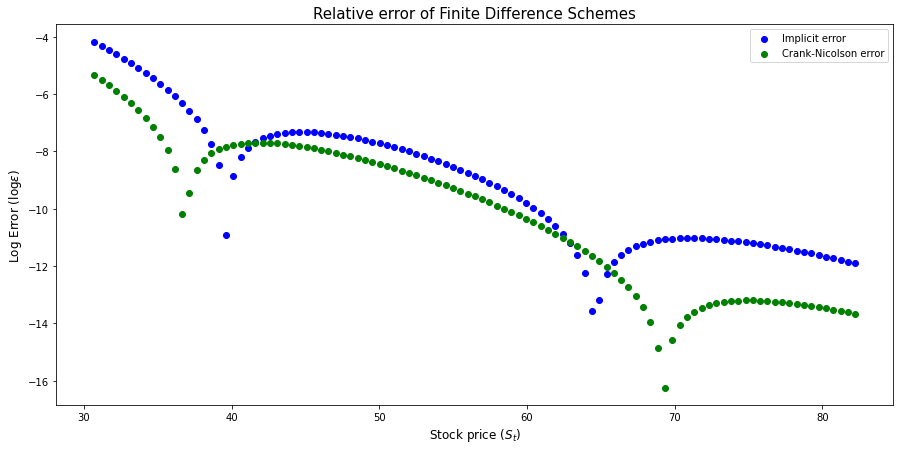

In [130]:
N = 500
M = 500
V_cn,t,S = pricing_call_crank_nicolson( K, 1, r, sigma, N, M)
V_imp,t,S = pricing_call_implicit( K, 1, r, sigma, N, M)
min_index = int(len(S)/8)
max_index = int(len(S)/3)
S_zoom = S[min_index:max_index]
V_true = mf.blackscholes(r, S_zoom, K, T, sigma, t=0, type="call")  # True price at time 0 for various current prices.
error_cn = np.log(abs(V_true - V_cn[0,min_index:max_index])/abs(V_true))
error_imp = np.log(abs(V_true - V_imp[0,min_index:max_index])/abs(V_true))
ax = plt.gca()
ax.scatter(S_zoom, error_imp, label='Implicit error', color='blue')
ax.scatter(S_zoom, error_cn, label='Crank-Nicolson error',color='green');
ax.set_xlabel('Stock price ($S_t$)',fontsize = 12)
ax.set_ylabel('Log Error ($\log \epsilon$)',fontsize = 12)
ax.legend(); 
plt.title('Relative error of Finite Difference Schemes',fontsize=15);

Notice the two spikes. My guess is that the error changes sign at the spikes, as a result the intermediate value theorem would lead you to expect that there will be some points where the error is almost zero. Other than that the key point is blue dots are above green dots implying Crank-Nicolson method gives less error than Implicit method.

---
## Summary

We can price options by solving the Black-Scholes PDE by a finite difference method. Lets review the steps:

 * You must specify the boundary of your grid and think how far out the top and bottom boundaries must be.
 * You must estimate the value on the top and bottom boundary.
 * You use the payoff to deterimne the final boundary.
 * You can then use a recurrence relation to compute the values away from the boundary.
 * The explicit method is easy to understand but can give silly answers due to *instability*.
 * The implicit method is stable, but requires solving linear equations.
 * The Crank-Nicolson method is stable and more accurate than the implicit method.
---

In [80]:
def top_boundary_for_put( K,T, S_max, r, t):
    return 0
        
def bottom_boundary_for_put( K,T, r, t):
    return exp(-r*(T-t))*K

def top_boundary_for_digital_call( K,T, S_max, r, t):
    return exp(-r*(T-t))
    
def bottom_boundary_for_digital_call( K,T, r, t):
    return 0
def heat_equation_matrix( dx, M):
   
    L = np.zeros((M-1,M-1))
    for i in range(0,M-2):
        L[i,i]=2/(dx)**2
        L[i+1,i]=-1/dx**2
        L[i,i+1]=-1/dx**2
    return L
    
dx = 0.2
M = 5
L = heat_equation_matrix( dx,M)
L

array([[ 50., -25.,   0.,   0.],
       [-25.,  50., -25.,   0.],
       [  0., -25.,  50., -25.],
       [  0.,   0., -25.,   0.]])